## Notebook para comparar RNN

<b>Vamos os dados do mfcc </b>
- Vamos testar sem dropouts nem regularizer

- Apenas regularizer

- Apenas dropout

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, Bidirectional
from sklearn.metrics import confusion_matrix
import keras
import os
import gc

In [7]:
def plot_graphs(m_metrics):
    class_labels = [i for i in range(10)]
    history = m_metrics.get('history_dict')
     
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history['accuracy'])
    axs[0].plot(history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = m_metrics.get('confusion_matrix')
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [2]:
def padding(path, duration = 4, sr = 44100):
    files = librosa.util.find_files(path)
    data = []

    for index, file_path in enumerate(files):
        try:
            audio, sr = librosa.load(file_path, sr=sr, mono=True)

            if len(audio) < duration*sr: # quando a duracao do audio for inferior aos 4 seg vamos adicionar padding
                audio = np.concatenate([audio,np.zeros(shape = (duration*sr - len(audio), ))])

            elif len(audio) > duration*sr: # quando a duracao do audio for superior aos 4 segs vamos reduzir a duracao
                audio = audio[:duration*sr]
        
            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception:
            print(f"Error in processig file {file_path}: {Exception}")

    return data


def feature_extraction(dataframe, audios):
    mfcc_coeficients = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]

                if not row.empty:
                    label = row.iloc[0,6]
                    mfcc = librosa.feature.mfcc(
                        y = audios[index][1],
                        n_mfcc = 13, 
                        hop_length = 512
                    )
                    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
                    mfcc_coeficients.append(mfcc)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    mfcc_coeficients = np.array(mfcc_coeficients)
    labels = np.array(labels)
    return mfcc_coeficients, labels

### Data Extraction

In [3]:
fold_paths = ["../UrbanSound8K/audio/fold1",
              "../UrbanSound8K/audio/fold2",
              "../UrbanSound8K/audio/fold3",
              "../UrbanSound8K/audio/fold4",
              "../UrbanSound8K/audio/fold5",
              "../UrbanSound8K/audio/fold6",
              "../UrbanSound8K/audio/fold7",
              "../UrbanSound8K/audio/fold8",
              "../UrbanSound8K/audio/fold9",
              "../UrbanSound8K/audio/fold10"]

df = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv")

features = np.empty((10,), dtype=object)
label = np.empty((10,), dtype=object)

for i, fold in enumerate(fold_paths):
    print(f"Processing Fold Number {i+1}")
    audio_data = padding(fold)

    mfcc, labels = feature_extraction(df, audio_data)
    mfcc = mfcc.transpose(0,2,1)
    
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    
    features[i] = mfcc
    label[i] = encoded_labels
    print("Features Shape: ",features[i].shape)
    print("Labels Shape: ",label[i].shape,"\n")
    
    del mfcc
    del labels
    del encoded_labels
    gc.collect() # libertar memoria

Processing Fold Number 1
Features Shape:  (873, 345, 13)
Labels Shape:  (873, 10) 

Processing Fold Number 2
Features Shape:  (888, 345, 13)
Labels Shape:  (888, 10) 

Processing Fold Number 3
Features Shape:  (925, 345, 13)
Labels Shape:  (925, 10) 

Processing Fold Number 4
Features Shape:  (990, 345, 13)
Labels Shape:  (990, 10) 

Processing Fold Number 5
Features Shape:  (936, 345, 13)
Labels Shape:  (936, 10) 

Processing Fold Number 6
Features Shape:  (823, 345, 13)
Labels Shape:  (823, 10) 

Processing Fold Number 7
Features Shape:  (838, 345, 13)
Labels Shape:  (838, 10) 

Processing Fold Number 8
Features Shape:  (806, 345, 13)
Labels Shape:  (806, 10) 

Processing Fold Number 9
Features Shape:  (816, 345, 13)
Labels Shape:  (816, 10) 

Processing Fold Number 10
Features Shape:  (837, 345, 13)
Labels Shape:  (837, 10) 



### Modelos

In [4]:
def create_model1(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh')))
    model.add(TimeDistributed(Dense(32, activation='tanh')))
    model.add(TimeDistributed(Dense(16, activation='tanh')))
    model.add(TimeDistributed(Dense(8, activation='tanh')))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

def create_model2(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

def create_model3(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(32, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(16, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(8, activation='tanh')))
    model.add(Dropout(0.3))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

### Definir fold
Vamos definir o fold 1 como teste e o fold 2 como validação

In [5]:
EPOCHS = 50
sets_treino_val = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0]] # [set_test,set_valid] | 0 = fold1 | 1 = fold2 | ...
X_test, y_test =[], []
X_val, y_val = [], []
X_train, y_train = [], []
fold = 0

# separar os dados(folds) em test(1) | validacao(1) | treino(8)
for i in range(10):
    if i == sets_treino_val[fold][0]:
        # set de teste
        X_test = features[i]
        y_test = label[i]
    elif i == sets_treino_val[fold][1]:
        # set de validacao
        X_val = features[i]
        y_val = label[i]
    else:
        # agrupar sets para treino
        if len(X_train) == 0:  # inicializar no primeiro fold de treino
            X_train = features[i]
            y_train = label[i]
        else:
            X_train = np.concatenate((X_train, features[i]), axis=0)
            y_train = np.concatenate((y_train, label[i]), axis=0)

# converter para np array caso ainda nao estejam
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)


### Sem dropout nem Regularizer

In [6]:
model = create_model1(345, 13)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics1 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics1)

c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 111s 371ms/step - accuracy: 0.1244 - loss: 2.3383 - val_accuracy: 0.1802 - val_loss: 2.1317
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 76s 349ms/step - accuracy: 0.2420 - loss: 2.0741 - val_accuracy: 0.1858 - val_loss: 2.6448
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 76s 350ms/step - accuracy: 0.2433 - loss: 2.0756 - val_accuracy: 0.2939 - val_loss: 2.1915
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 77s 354ms/step - accuracy: 0.2841 - loss: 1.9546 - val_accuracy: 0.2511 - val_loss: 2.1743
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 76s 350ms/step - accuracy: 0.3030 - loss: 1.8845 - val_accuracy: 0.2736 - val_loss: 1.9665
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 86s 395ms/step - accuracy: 0.3221 - loss: 1.8429 - val_accuracy: 0.3345 - val_loss: 1.9242
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 440ms/step - accuracy: 0.3346 - loss: 1.8149 - val_accuracy: 0.3547 - val_loss: 1.8326
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 441ms/step - accuracy: 0.3333 - loss: 

NameError: name 'plot_graphs' is not defined

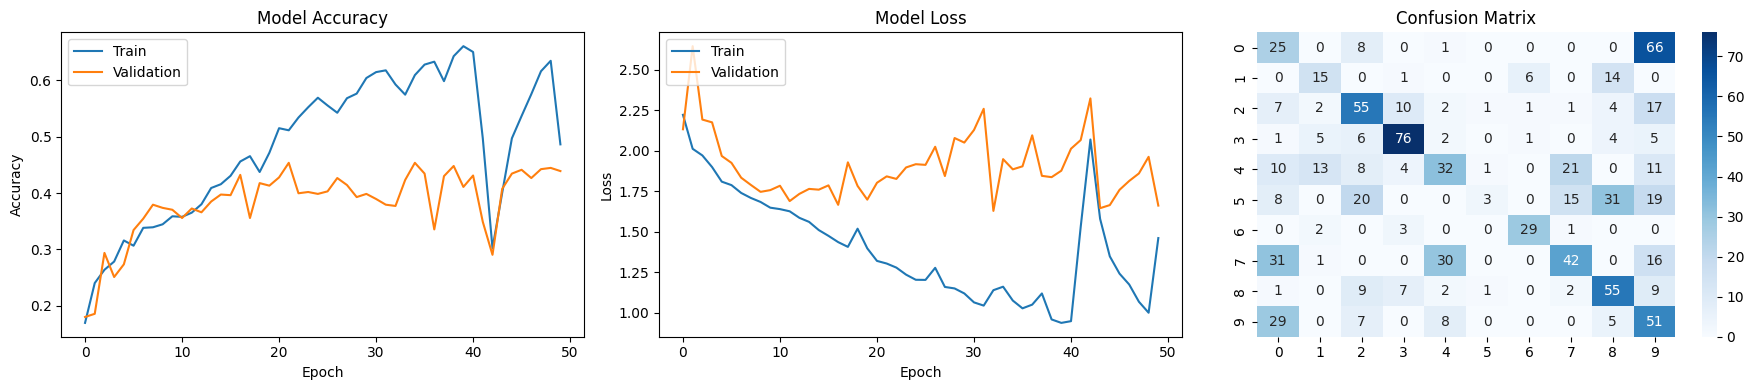

In [8]:
plot_graphs(m_metrics1)

### Apenas regularizer

c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 110s 363ms/step - accuracy: 0.1305 - loss: 3.9393 - val_accuracy: 0.1937 - val_loss: 3.1493
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 345ms/step - accuracy: 0.2335 - loss: 3.0649 - val_accuracy: 0.2230 - val_loss: 2.8216
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 346ms/step - accuracy: 0.2532 - loss: 2.6778 - val_accuracy: 0.2827 - val_loss: 2.5247
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 346ms/step - accuracy: 0.2645 - loss: 2.4377 - val_accuracy: 0.3288 - val_loss: 2.3656
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 345ms/step - accuracy: 0.2945 - loss: 2.2755 - val_accuracy: 0.3266 - val_loss: 2.2071
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 345ms/step - accuracy: 0.2904 - loss: 2.1372 - val_accuracy: 0.3491 - val_loss: 2.0399
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 346ms/step - accuracy: 0.2963 - loss: 2.0407 - val_accuracy: 0.3637 - val_loss: 2.0477
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 345ms/step - accuracy: 0.3101 - loss: 

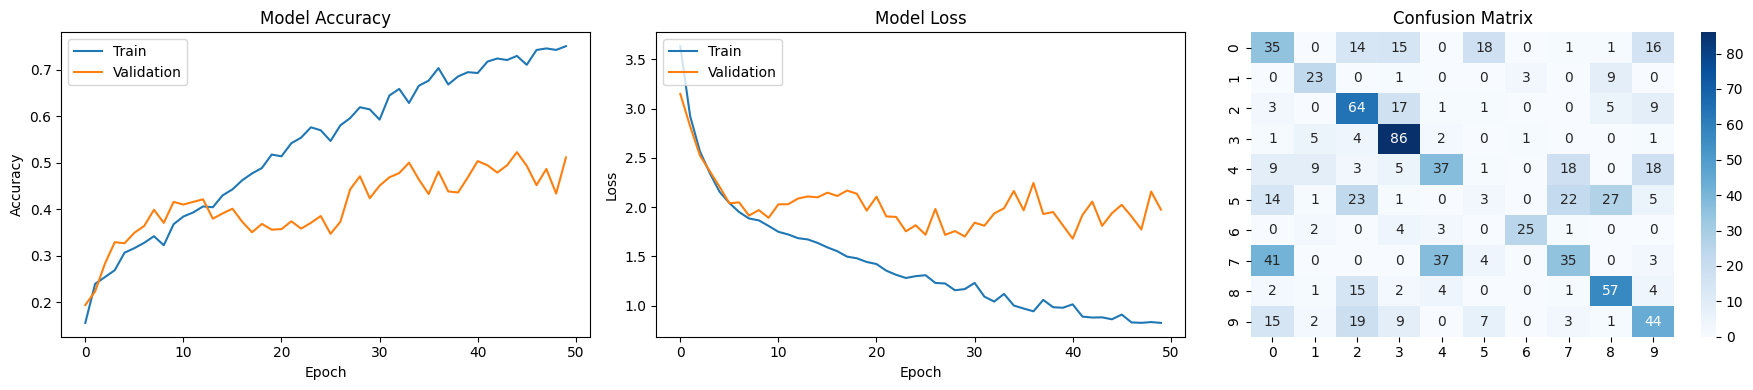

In [9]:
model = create_model2(345, 13)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics2 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics2)

### Apenas dropout

Epoch 1/50


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - accuracy: 0.1288 - loss: 2.5373 - val_accuracy: 0.2083 - val_loss: 2.3543
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 336ms/step - accuracy: 0.2150 - loss: 2.1166 - val_accuracy: 0.2151 - val_loss: 2.1432
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 337ms/step - accuracy: 0.2617 - loss: 2.0181 - val_accuracy: 0.3209 - val_loss: 2.1077
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 337ms/step - accuracy: 0.2641 - loss: 1.9697 - val_accuracy: 0.2646 - val_loss: 2.0213
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 74s 338ms/step - accuracy: 0.2913 - loss: 1.9491 - val_accuracy: 0.3311 - val_loss: 1.9351
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 336ms/step - accuracy: 0.3036 - loss: 1.8708 - val_accuracy: 0.3356 - val_loss: 1.9064
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 337ms/step - accuracy: 0.2979 - loss: 1.8509 - val_accuracy: 0.3536 - val_loss: 1.8727
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 337ms/step - accuracy: 0.3255 - loss: 1.8263 - va

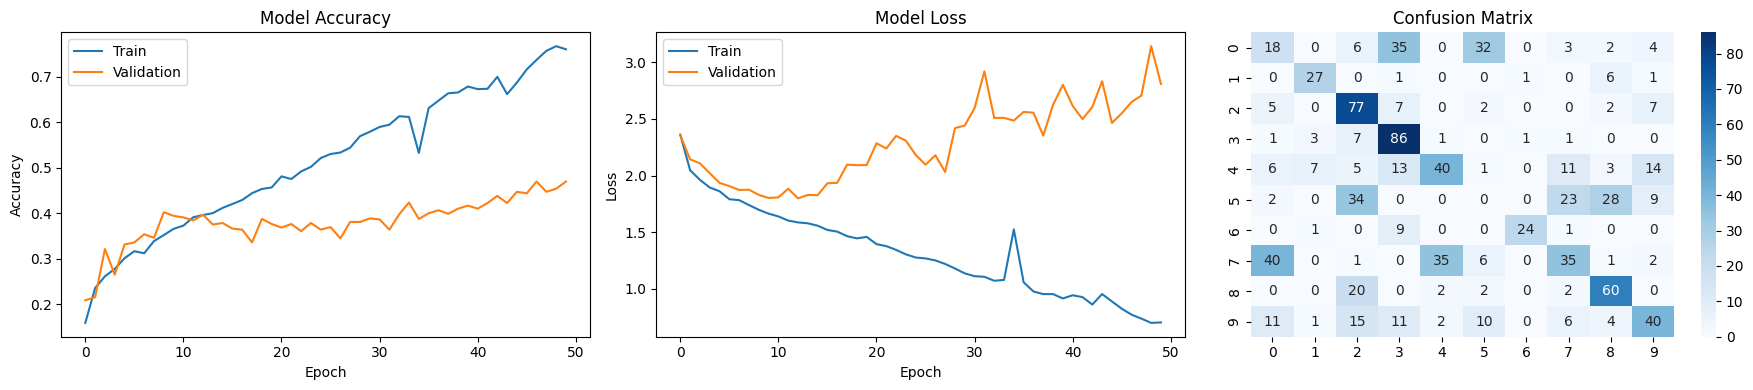

In [10]:
model = create_model3(345, 13)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics3 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics3)